In [1]:
import keras_cv 
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import os
import numpy as np
import pandas as pd
import pycocotools
from src.config import RAW_DATA_DIR

/Users/Edward/DS/Projects/ckd-cdss/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-11-17 17:19:30.728 | INFO     | src.config:<module>:12 - PROJ_ROOT path is: /Users/Edward/DS/Projects/ckd-cdss


In [2]:
# Constants
DIPSTICK_IMAGES_DIR = RAW_DATA_DIR / "dipstick_imgs"
IMAGE_SIZE = (640, 640)
AUTOTUNE = tf.data.AUTOTUNE # Used for configuring parallelism in TensorFlow's data loading pipeline
BBOX_FORMAT = 'xywh' # Indicating the format of bounding boxes
BATCH_SIZE = 4

In [ ]:
# Load COCO annotations (adjust the paths accordingly)
coco_annotation_file_train = DIPSTICK_IMAGES_DIR / "train/labels/_annotations.coco.json"
coco_image_dir_train = DIPSTICK_IMAGES_DIR / "train/images"
coco_train = pycocotools.coco.COCO(coco_annotation_file_train)

coco_annotation_file_val = DIPSTICK_IMAGES_DIR / "valid/labels/_annotations.coco.json"
coco_image_dir_val = DIPSTICK_IMAGES_DIR / "valid/images"
coco_val = pycocotools.coco.COCO(coco_annotation_file_val)


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.00s)
creating index...
index created!


In [4]:
def normalize_bbox(inputs):
    image = inputs["image"]
    normalized_bbox = keras_cv.bounding_box.convert_format(
        inputs["objects"]["bbox"],
        images=image,
        source="xywh",
        target=BBOX_FORMAT,
    )
    return normalized_bbox


def get_annotations_for_image(image_id, coco):
    # Get annotations for the specified image ID from COCO dataset
    annotation_ids = coco.getAnnIds(imgIds=image_id)
    annotations = coco.loadAnns(annotation_ids)

    bounding_boxes = []
    labels = []

    for annotation in annotations:
        bbox = annotation['bbox']  # Format: [x, y, width, height]
        label = annotation['category_id']  # keep all categories
        bounding_boxes.append(bbox)
        labels.append(label)

    return {'boxes': bounding_boxes, 'labels': labels}


def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    return img


def load_coco_dataset(image_ids, coco, coco_image_dir):
    images = []
    boxes_list = []
    labels_list = []

    for imgid in image_ids:
        img = coco.loadImgs(imgid)[0]
        img_name = img['file_name'].strip()
        img_path = os.path.join(coco_image_dir, img_name)

        if os.path.isfile(img_path) and os.path.getsize(img_path):
            annotations = get_annotations_for_image(imgid, coco)
            if len(annotations['boxes']) > 0 and len(annotations['labels']) > 0:
                images.append(img_path)
                boxes_list.append(annotations['boxes'])
                labels_list.append(annotations['labels'])
    
    return images, boxes_list, labels_list


def load_dataset(image_path, classes, bbox):
    image = decode_and_resize(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}


def make_dataset(m, n, coco, coco_image_dir):
    image_ids = coco.getImgIds()[m:n]
    image_paths, bbox, classes = load_coco_dataset(image_ids, coco, coco_image_dir)
    bbox = tf.ragged.constant(bbox)
    classes = tf.ragged.constant(classes)
    image_paths = tf.ragged.constant(image_paths)

    dataset = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))
    dataset = dataset.map(load_dataset, num_parallel_calls=AUTOTUNE)
    dataset = dataset.ragged_batch(BATCH_SIZE, drop_remainder=True)
    dataset = dataset.shuffle(8 * BATCH_SIZE)
    dataset = dataset.apply(tf.data.experimental.ignore_errors())
    dataset = dataset.prefetch(AUTOTUNE)
    
    return dataset


In [5]:
train_dataset = make_dataset(0,40, coco_train, coco_image_dir_train)
val_dataset = make_dataset(0,500, coco_val, coco_image_dir_val)

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


In [6]:
def get_class_mapping(coco):
    # Load all categories from the COCO dataset
    categories = coco.loadCats(coco.getCatIds())
    # Map category_id (from JSON) to category name
    class_mapping = {category['id']: category['name'] for category in categories}
    return class_mapping

# Build mapping for training dataset
class_mapping = get_class_mapping(coco_train)

# Number of classes is simply the number of categories
num_classes = len(class_mapping)


def visualize_dataset(inputs, rows, cols):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    keras_cv.visualization.plot_bounding_box_gallery(
        images,
        value_range=(0,255),
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=BBOX_FORMAT,
        class_mapping=class_mapping,
    )

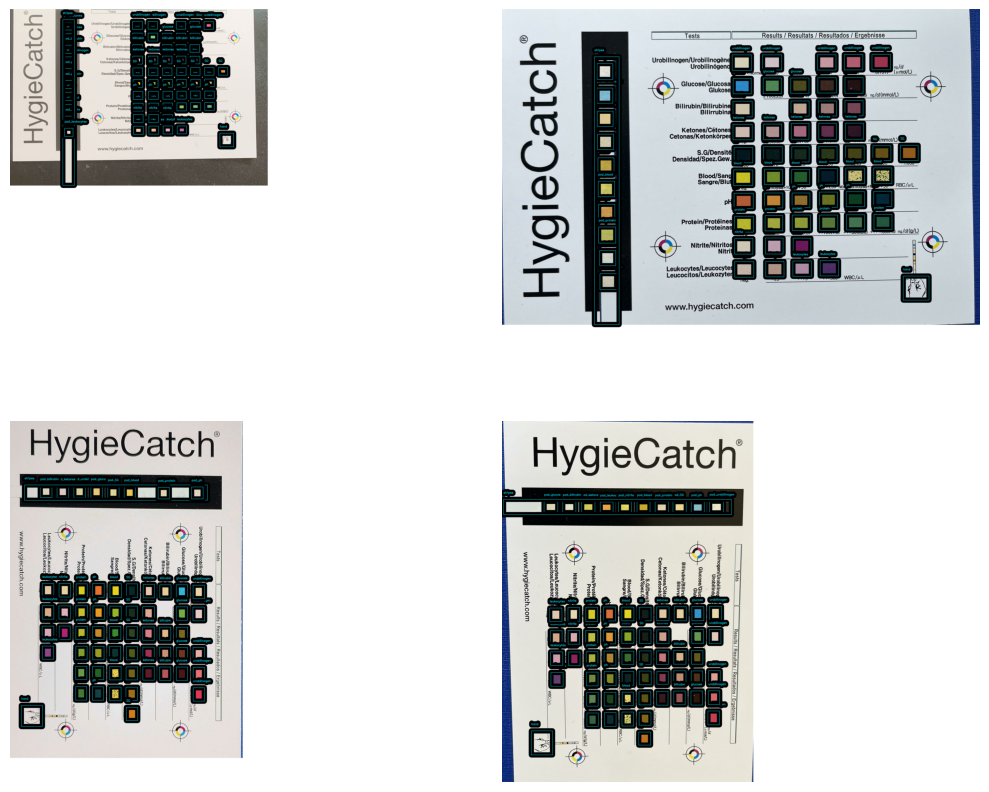

In [ ]:
visualize_dataset(train_dataset, rows=3, cols=2)

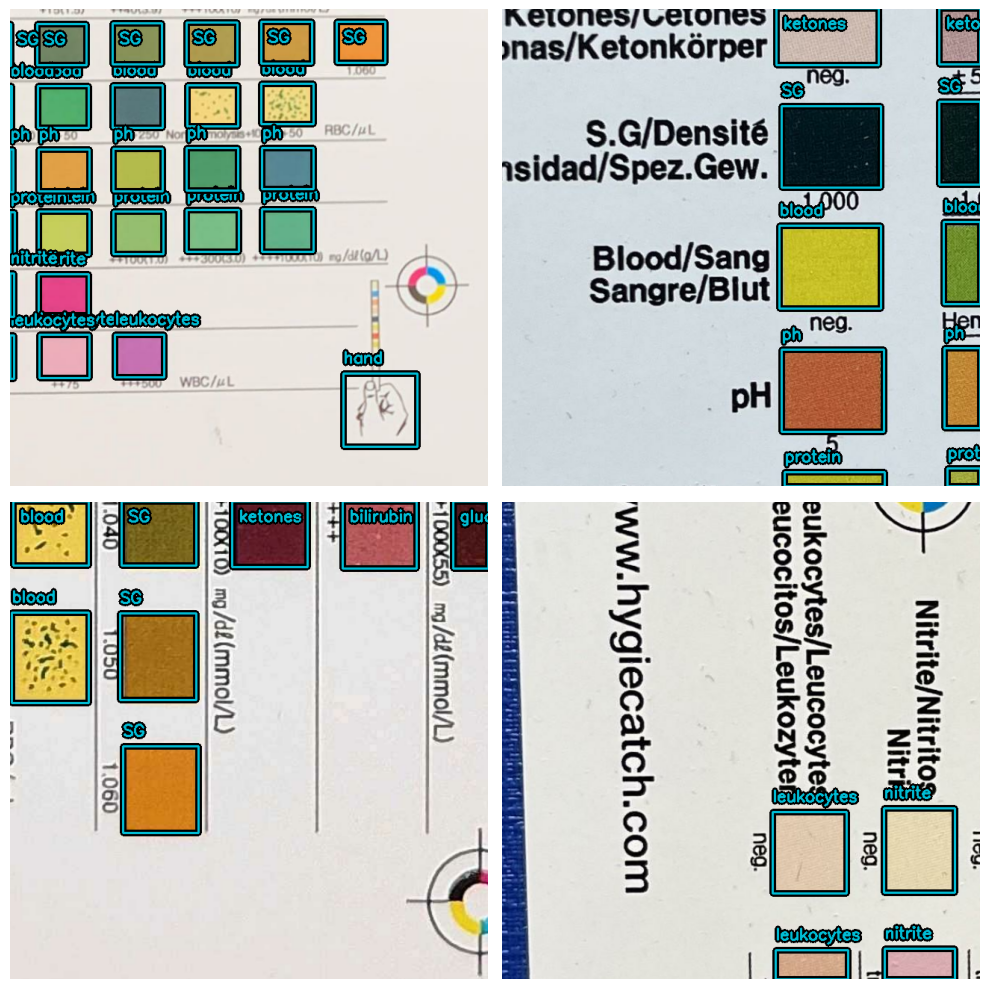

In [8]:
augmenters = [
    keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format=BBOX_FORMAT),
    keras_cv.layers.JitteredResize(
        target_size=IMAGE_SIZE, scale_factor=(0.75, 1.3), bounding_box_format=BBOX_FORMAT
    ),
]


def create_augmenter_fn(augmenters):
    def augmenter_fn(inputs):
        for augmenter in augmenters:
            inputs = augmenter(inputs)
        return inputs

    return augmenter_fn


augmenter_fn = create_augmenter_fn(augmenters)

train_dataset = train_dataset.map(augmenter_fn, num_parallel_calls=AUTOTUNE)
visualize_dataset(train_dataset, rows=2, cols=2)

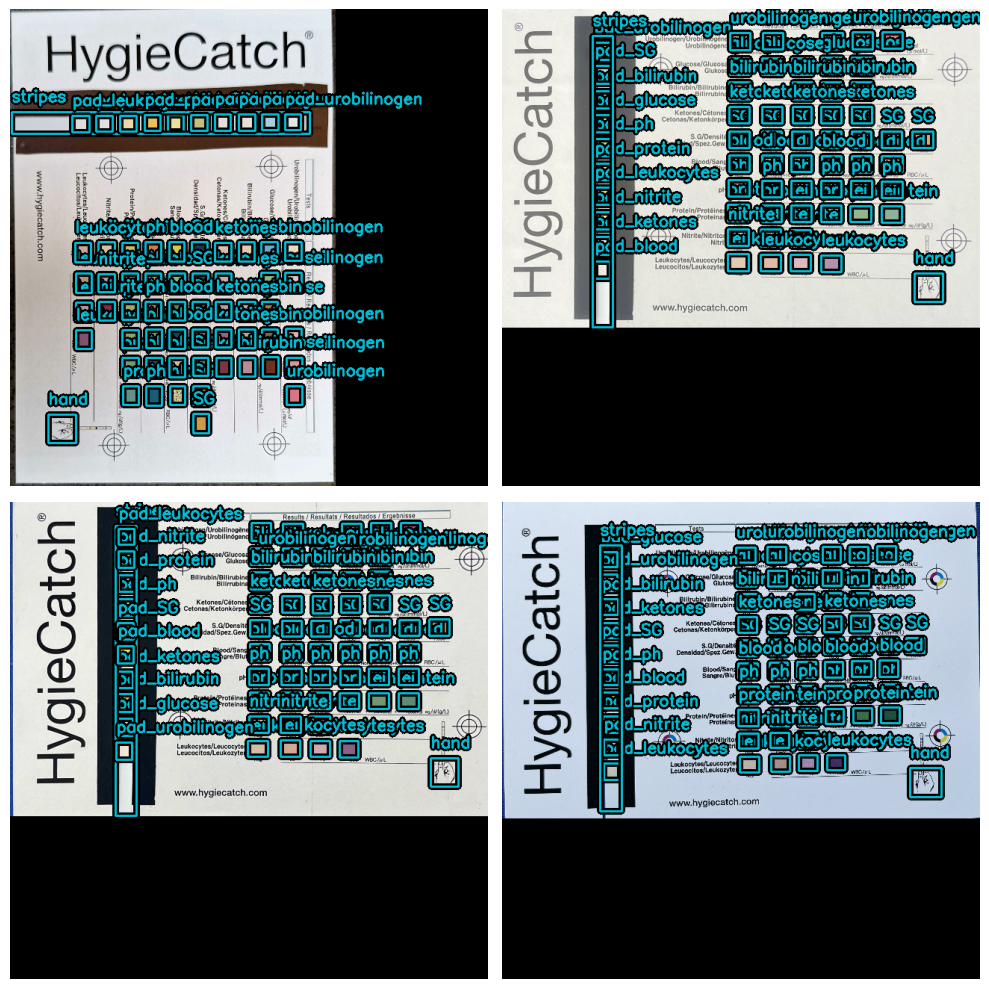

In [9]:
inference_resizing = keras_cv.layers.Resizing(
    IMAGE_SIZE[0], IMAGE_SIZE[1], bounding_box_format=BBOX_FORMAT, pad_to_aspect_ratio=True
)
val_dataset = val_dataset.map(inference_resizing, num_parallel_calls=AUTOTUNE)
visualize_dataset(val_dataset, rows=2, cols=2)